### Analysis of Nanopore long reads

During sequencing, the reads have already been filtered for quality, i.e. only reads with a Q-score >= 8 are kept. 
Also, alignment was performed by the Minion software after sequencing and basecalling. 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pysam
from functions_ import *
from plotting import *
from utils import *
import csv
from Nanopore_functions import *
from characterization_from_blast_alignments import *
from Bio import SeqIO
from matplotlib import patches
import gzip 
from matplotlib.colors import LinearSegmentedColormap
import ast 
import json 
ref_WT = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaatgtccgcggaagcgcagaacgatccgctgctgccgggctatagctttaacgcgcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgcgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccgctatagcgaactgctggcgattaacctgctggaacagctgctgctgcgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccgagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccgcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper()

ref_R5 = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaAtgtccgAggaagcgcagaacgatccgctgctgccgggctatagctttaacgcgcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgcgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccgctatagcgaactgctggcgattaacctgAtAgaacagctgctgctgcgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccgagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccAcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper() ## R5

ref_R2 = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaAtgtccgcgAaagcgcagaacgatccgctgctgccgggctatagctttaacgcAcatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgAgaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggccTctatagcgaactgctgAcAattaacctgctggaacagctgctgctgcgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagcccTagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggccTcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtGAACGATGTGGCGGTGAAACTGAGCGGGTAAggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper() ## R2

annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294'] #'*294'

annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']#'*294'

In [377]:
from importlib import reload
import characterization_from_blast_alignments
reload(characterization_from_blast_alignments)
from characterization_from_blast_alignments import *

import Nanopore_functions
reload(Nanopore_functions)
from Nanopore_functions import *


In [378]:
for barcode in range(13,22):
    input_folder = f"/home/student/anna/DMS_analysis/data/Nanopore_P0115/barcode{barcode}/highly_accurate_basecalling/filtered_Q20_maxminlen/"
    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/barcode{barcode}/"
    if not os.path.exists(FigFolder):
        os.makedirs(FigFolder)

    all_left_linkers, all_right_linkers = get_linker_regions(input_folder= input_folder+ "minimap2_alignment", ref = ref_R2, cut_site_seq_left= "gccacaa".upper(), cut_site_seq_right= "tgctgaaaac".upper(), left_linker_region_len= 12*3, right_linker_region_len= 20*3)

    read_dir = "R2"
    right_linkers_counts, right_linkers_list = get_linker_variants_for_Nanopore(linker_alignments=all_right_linkers, wt_linker = "INESSGL" if read_dir=="R1" else "IDEAAKGSHLPP", read_dir = read_dir)

    # sort linkers by frequency
    linkers_sorted = {k: v for k, v in sorted(right_linkers_counts.items(), key=lambda item: item[1], reverse=True)}
    total_reads = sum(linkers_sorted.values())
    linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}
# exclude wt and linkers with less than 0.05% frequency
    linkers_sorted_perc.pop("wt")
    linkers_perc_filt, right_linker_renaming = rename_right_linkers(linkers_sorted_perc.keys(), linkers_sorted_perc)
    
    linkers_perc_filt = {k: v for k, v in linkers_perc_filt.items() if v > 0.1}

    ### plot linker variants
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values(), color ="black")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of reads")
    plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title(f"Linker variants for {barcode} {read_dir}")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.pdf", bbox_inches="tight")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.png", bbox_inches="tight")
    plt.close()

    linkers_perc_filt = pd.DataFrame.from_dict(linkers_perc_filt, orient="index")
    linkers_perc_filt.to_csv(f"{FigFolder}/linker_distribution_{read_dir}.csv")

    read_dir = "R1"
    left_linkers_counts, left_linker_list = get_linker_variants_for_Nanopore(linker_alignments=all_left_linkers, wt_linker = "INESSGL" if read_dir=="R1" else "IDEAAKGSHLPP", read_dir = read_dir)

    # sort linkers by frequency
    linkers_sorted = {k: v for k, v in sorted(left_linkers_counts.items(), key=lambda item: item[1], reverse=True)}
    total_reads = sum(linkers_sorted.values())
    linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

    # exclude wt and linkers with less than 0.05% frequency
    linkers_sorted_perc.pop("wt")

    linkers_perc_filt, left_linker_renaming = rename_left_linkers(linkers_sorted_perc.keys(), linkers_sorted_perc)

    linkers_perc_filt = {k: v for k, v in linkers_perc_filt.items() if v > 0.1}


    ### plot linker variants
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values(), color ="black")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of reads")
    plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title(f"Linker variants for {barcode} {read_dir}")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.pdf", bbox_inches="tight")
    plt.savefig(f"{FigFolder}/linker_distribution_{read_dir}.png", bbox_inches="tight")
    plt.close()

    linkers_perc_filt = pd.DataFrame.from_dict(linkers_perc_filt, orient="index")
    linkers_perc_filt.to_csv(f"{FigFolder}/linker_distribution_{read_dir}.csv")

    cooccurrences = []
    for idx, right_linker in enumerate(right_linkers_list): 
        if right_linker == "": 
            continue
        left_linker = left_linker_list[idx] 
        right_linker_renamed = right_linker_renaming[right_linker] if right_linker != "wt" else "wt"
        left_linker_renamed = left_linker_renaming[left_linker] if left_linker != "wt" else "wt"

        cooccurrences.append(f"{left_linker_renamed}_{right_linker_renamed}")
    
    with open(f"{FigFolder}/cooccurrences.txt", "w") as f: 
        f.write("\n".join(cooccurrences))
    
    with open(f"{FigFolder}/linker_renaming_left_linker.json", "w") as f:
        json.dump(left_linker_renaming, f, indent=4)
    
    with open(f"{FigFolder}/linker_renaming_right_linker.json", "w") as f:
        json.dump(right_linker_renaming, f, indent=4)
    
    if not os.path.exists(f"{input_folder}/processed_reads"):
        os.makedirs(f"{input_folder}/processed_reads")
        
    with open(f"{input_folder}/processed_reads/all_left_linkers.jso", "w") as f:
        json.dump(all_left_linkers, f, indent=4)
    
    with open(f"{input_folder}/processed_reads/all_right_linkers.json", "w") as f:
        json.dump(all_right_linkers, f, indent=4)
    
        
    print("Barcode", barcode, "done")   


10925 reads excluded due to frameshifts
IDEAAKRLHPP -> R
IDEAAKKLHPP -> K
IDEAAKGSLHPP -> GS
IDKAAKKLHPP -> (-3del)AAKK
IDEAAKSLHPP -> S
IDEAAKALHPP -> A
IDEAAKNLHPP -> N
IDEAAKQLHPP -> Q
IDEAAKGLHPP -> G
IDEAAKGRGLHPP -> GRG
IDEAAKGSLRPP -> GSLR(+2del)
IDEAAKTLHPP -> T
IDEAAKHLHPP -> H
IDEAAKKKLHPP -> KK
IDEAAEGSLHPP -> (-1del)EGS
IDEAAKGAGLHPP -> GAG
IDEAAKVLHPP -> V
IDEAAKCLHPP -> C
IDEAAKRSLHPP -> RS
IDEAAKMLHPP -> M
IDEVAKGSLHPP -> (-3del)VAKGS
IDEAAKGGLHPP -> GG
IDEAAKLLHPP -> L
IHEAAKGSLHPP -> (-5del)HEAAKGS
IDEAAKGCGLHPP -> GCG
IDEAAKGVGLHPP -> GVG
IDEAAKKGSLHPP -> KGS
IDEAAKILHPP -> I
IDEAAKGIGLHPP -> GIG
IDEAAKELHPP -> E
IDEAAKKNWHPP -> KNW(+1del)
IDEAAKGSLHLP -> GSLHL(+3del)
IDEAAKGSGGLHPP -> GSGG
IDEAAKGSLHP -> GSLH(+3del)
IDEAAKFLHPP -> F
IDEAAKGSLHLL -> GSLHLL(+4del)
IDEAAKDLHPP -> D
IDEAAKGSLHPPM -> GSLHPPM(+4del)
IDEAAKGKGLHPP -> GKG
IEAAAKGSGLHPP -> (-2del)AKGSG
IDEAAKGNLHPP -> GN
IDEAAGSLHPP -> (-1del)GS
IDEAAKGSGLHPP -> GSG
IGSLHPP -> (-5del)GS
IDEAAKEGSLHPP -> EGS
I

In [495]:
all_cooccs = {}
all_linker_vars = []
barcodes =  [13, 16, 17,19, 21]#[13, 14, 15,18, 20]
for barcode in barcodes: 
    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/barcode{barcode}/"
    with open(f"{FigFolder}/cooccurrences.txt", "r") as f:
        cooccurrences = f.read().split("\n")
    cooccs_counts = dict(Counter(cooccurrences))

    cooccs_perc = {k: v/sum(cooccs_counts.values())*100 for k, v in cooccs_counts.items()}
    cooccs_perc_filt = {k: v for k, v in cooccs_perc.items() if v > 1}.copy()

    ## normalize filtered cooccs_perc
    cooccs_perc_filt_norm =  {k: v/sum(cooccs_perc_filt.values())*100 for k, v in cooccs_perc_filt.items()}


    all_linker_vars = list(set(all_linker_vars+ list(cooccs_perc_filt_norm.keys())))

    all_cooccs[barcode] = cooccs_perc_filt_norm


all_cooccs_df = pd.DataFrame(index = [str(bc) for bc in barcodes], columns = all_linker_vars, data = 0.0)

for barcode in barcodes:
    for linker in all_linker_vars:
        all_cooccs_df.loc[str(barcode), linker] = all_cooccs[barcode].get(linker, 0)


    

In [496]:
## filter df for linkers that have a overall occurrence of higher than 10 % 
all_cooccs_df = all_cooccs_df.loc[:, all_cooccs_df.sum() > 3]

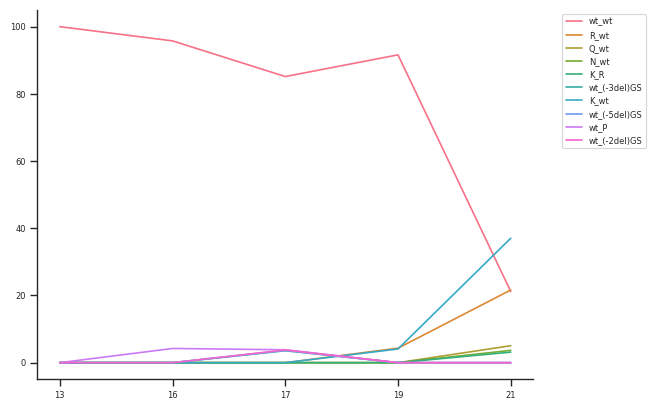

In [497]:
colors = ["#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"
     ] # Light green

  # Number of distinct colors
colors = sns.color_palette("husl", all_cooccs_df.shape[1]) 


for i in all_cooccs_df.columns:
    plt.plot(all_cooccs_df[i], label = i, color = colors[all_cooccs_df.columns.get_loc(i)])
## put legend on right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [508]:
## Nanopore P0115
ref_R2 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCTAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCTCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:]

In [509]:
barcodenumbers = ["01" ,"02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "23" ]

In [510]:
for barcodenumber in barcodenumbers:
    barcode = "barcode"+barcodenumber
    data_folder = "Nanopore_P0115"
    quality = 20

    with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
        reader = csv.reader(f)
        all_reads = list(reader)  # Convert the reader object into a list

    all_reads = [read[0] for read in all_reads]
    # Print the data
    print(len(all_reads))

    indels = pd.read_csv(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0)


    data_type = "AA"
    ref = ref_R2#ref_R5 if barcode in ["barcode06", "barcode07", "barcode08", "barcode09"] else ref_R2
    annots = annots_R2#annots_R5 if barcode in ["barcode06", "barcode07", "barcode08", "barcode09"] else annots_R2

    start_arac =ref.index("ttttttggagtaaggaggaaaa".upper()) + len("ttttttggagtaaggaggaaaa")## ref = ref seq right before AraC start #start_arac =297-9
    end_arac = ref.index("ggctaatggagattttcaacatgggct".upper()) ## ref seq right after AraC end #indels.shape[1]-355+3
    indels = indels/len(all_reads)#297-9

    all_variants, enrichment_counts,enrichment_relative, indels_freq = characterize_DMS_Nanopore(aligned_reads = all_reads, ref = ref, data_type = data_type) #ref[9:]


    # araclov2_enr = enrichment_relative.iloc[:,(297-9)//3:-355//3]
    # araclov2_enr.columns = annots_R5
    output_folder = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    enrichment_counts.to_csv(f"{output_folder}/enrichment_counts_{data_type}.csv")
    enrichment_relative.to_csv(f"{output_folder}/enrichment_relative_{data_type}.csv")
    all_variants.to_csv(f"{output_folder}/all_variants_{data_type}.csv")

    if data_type == "AA": 
        araclov2_enr = enrichment_relative.iloc[:,start_arac//3:end_arac//3]#[:,(297-9)//3:(-355+3)//3]
        araclov2_enr.columns = annots
        araclov2_enr.to_csv(f"/{output_folder}/enrichment_relative_roi_{data_type}.csv")

    print("Barcode"+barcodenumber+" done")

79412
72133 sequences have off target indels
79412 sequences are included in the enrichment analysis
Barcode01 done
158505
145280 sequences have off target indels
158505 sequences are included in the enrichment analysis
Barcode02 done
89578
81629 sequences have off target indels
89578 sequences are included in the enrichment analysis
Barcode03 done
103970
95444 sequences have off target indels
103970 sequences are included in the enrichment analysis
Barcode04 done
138826
128015 sequences have off target indels
138826 sequences are included in the enrichment analysis
Barcode05 done
135370
125520 sequences have off target indels
135370 sequences are included in the enrichment analysis
Barcode06 done
139109
128269 sequences have off target indels
139109 sequences are included in the enrichment analysis
Barcode07 done
152482
140507 sequences have off target indels
152482 sequences are included in the enrichment analysis
Barcode08 done
183161
167529 sequences have off target indels
183161 s

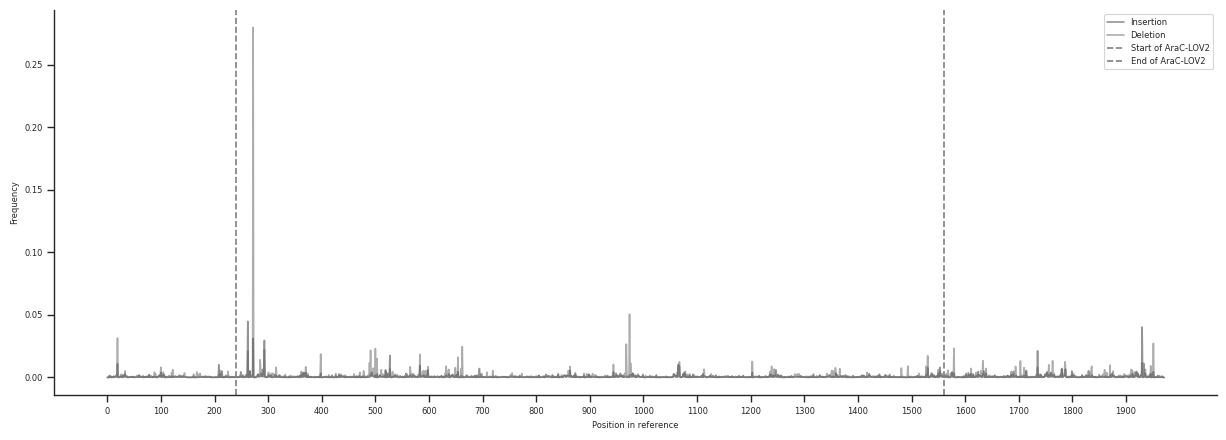

In [128]:
fig, axes = plt.subplots(figsize=(15, 5))
plt.plot(indels.loc["I"], label = "Insertion", alpha = 0.5)
plt.plot(indels.loc["D"], label = "Deletion", alpha = 0.5)
plt.axvline(start_arac -48, color = "grey", linestyle = "--", label = "Start of AraC-LOV2")
plt.axvline(end_arac-48, color = "grey", linestyle = "--", label = "End of AraC-LOV2")
plt.xticks(list(range(0, len(indels.columns), 100)), list(range(0, len(indels.columns), 100)))
plt.xlabel("Position in reference")
plt.ylabel("Frequency")
plt.legend()
plt.show()

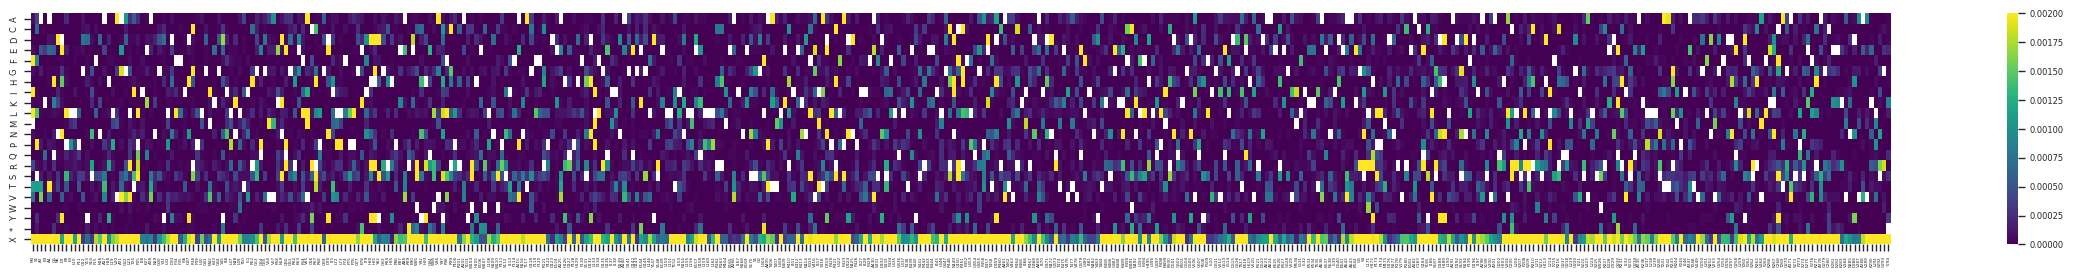

In [129]:
fig, axes = plt.subplots(figsize = (30, 3))
sns.heatmap(araclov2_enr, cmap = "viridis", xticklabels = annots_R2, yticklabels=True, vmax = 0.002)
axes.set_xticklabels(axes.get_xticklabels(),fontsize = 3)
plt.show()

KeyError: 'barcode23'

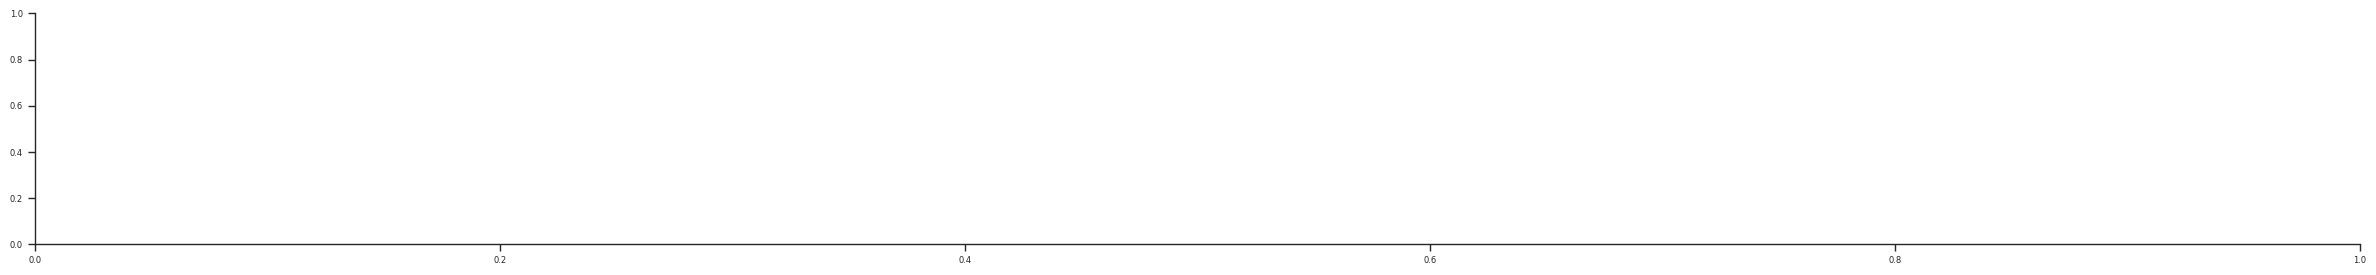

In [53]:
fig, axes = plt.subplots(figsize = (30, 3))
sns.heatmap(enrichments["barcode23"], cmap = my_cmap, xticklabels = annots_R2, yticklabels=True, vmax = 0.002)
axes.set_xticklabels(axes.get_xticklabels(),fontsize = 3)
plt.show()

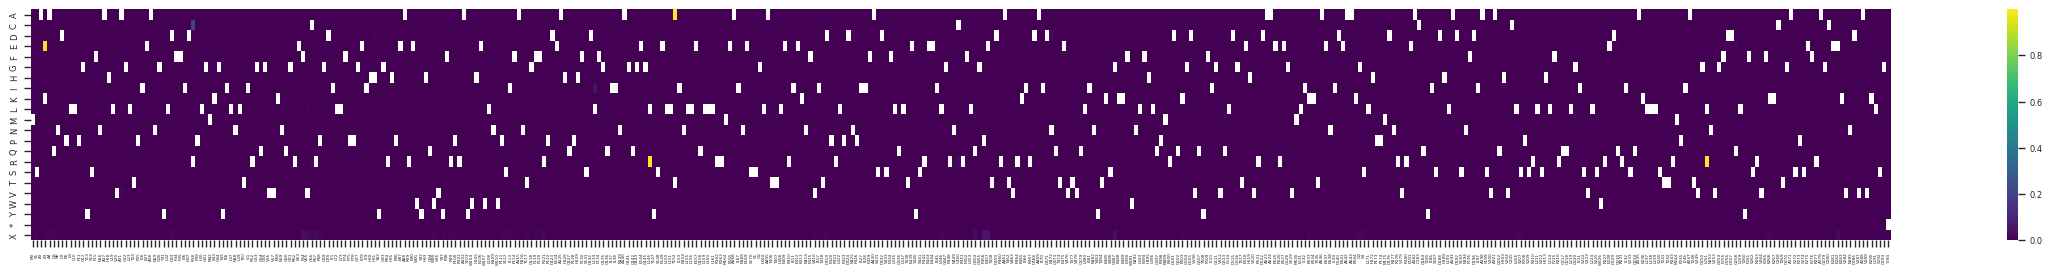

In [165]:
fig, axes = plt.subplots(figsize = (30, 3))
sns.heatmap(enrichments["barcode23"], cmap = "viridis", xticklabels = annots_R2, yticklabels=True, vmax =None)
axes.set_xticklabels(axes.get_xticklabels(),fontsize = 3)
plt.show()

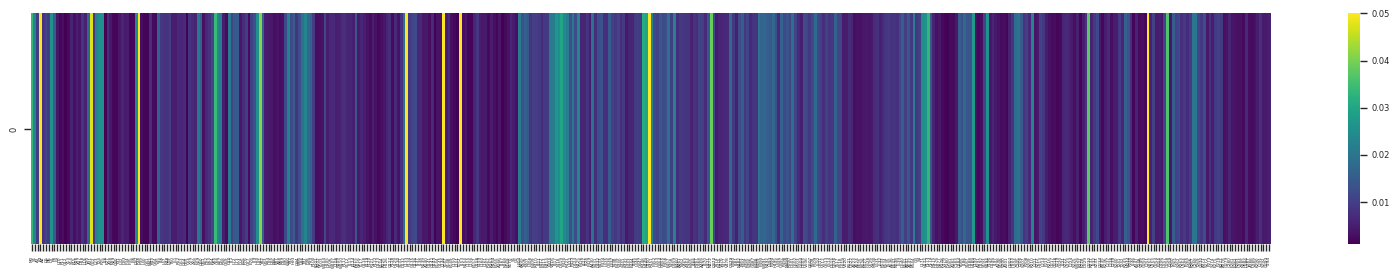

In [121]:
fig, axes = plt.subplots(figsize = (20, 3))
sns.heatmap(pd.DataFrame(araclov2_enr.iloc[:-1].sum()).T, cmap = "viridis", xticklabels = annots_R2, yticklabels=True, vmax = 0.05)
axes.set_xticklabels(axes.get_xticklabels(),fontsize = 3)
plt.show()

In [46]:
### the code was taken and adapted from https://dmnfarrell.github.io/python/fastq-quality-python ####

filename = f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/filtered_fastq/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.fastq.gz"

fastq_parser = SeqIO.parse(gzip.open(filename,"rt"), "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
############ correct for coverage
df = df.fillna(0)

NameError: name 'enrichment_relative' is not defined

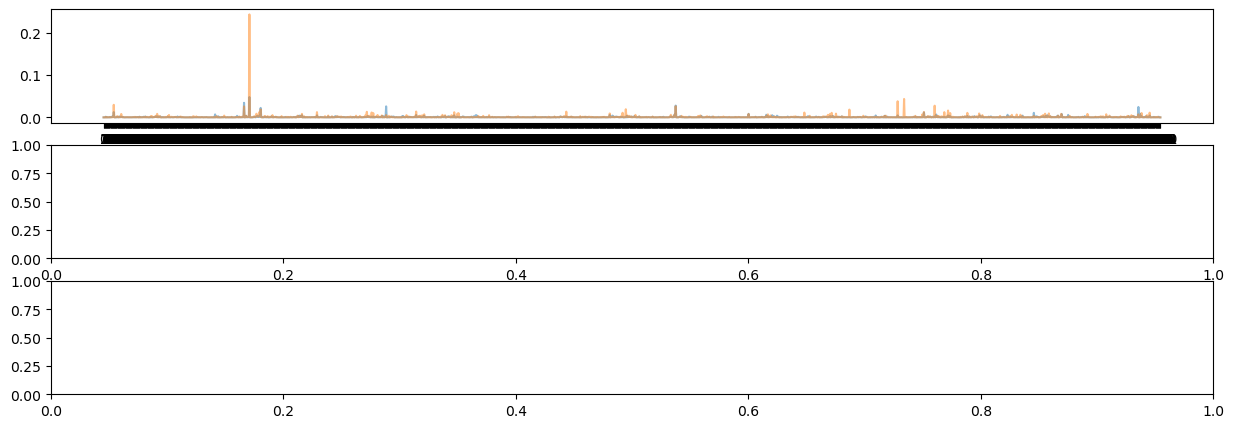

In [7]:
n_cut = 9
fig, axes = plt.subplots(3,1, figsize=(15, 5))
axes[0].plot(indels.loc["I"], label = "Insertion", alpha = 0.5)
axes[0].plot(indels.loc["D"], label = "Deletion", alpha = 0.5)
axes[0].set_xlim(n_cut, len(enrichment_relative.columns))
axes[0].set_xticks(list(range(n_cut, len(enrichment_relative.columns), 100)))
axes[0].set_xticklabels([])
axes[0].axvline(start_arac, color = "grey", linestyle = "--", label = "Start of AraC-LOV2")
axes[0].axvline(end_arac, color = "grey", linestyle = "--", label = "End of AraC-LOV2")
axes[0].legend(fontsize = 8, frameon = False)
axes[0].set_ylabel("Frequency")

rect = patches.Rectangle((0,0),len(df.iloc[:,:indels.shape[1]].columns),20,linewidth=0,facecolor='r',alpha=.4)
axes[1].add_patch(rect)
rect = patches.Rectangle((0,20),len(df.iloc[:,:indels.shape[1]].columns),8,linewidth=0,facecolor='yellow',alpha=.4)
axes[1].add_patch(rect)
rect = patches.Rectangle((0,28),len(df.iloc[:,:indels.shape[1]].columns),12,linewidth=0,facecolor='g',alpha=.4)
axes[1].add_patch(rect)
df.iloc[:,:indels.shape[1]].mean().plot(ax=axes[1],c='black')
boxprops = dict(linestyle='-', linewidth=0.1, color='black')
df.iloc[:,:indels.shape[1]].plot(kind='box', ax=axes[1], grid=False, showfliers=False, 
        color=dict(boxes='black',whiskers='black'), boxprops=boxprops,     whiskerprops={'linewidth': 0.1} ) # Adjust linewidth as needed)
axes[1].set_xlim(n_cut, len(enrichment_relative.columns))
axes[1].set_xticks(list(range(n_cut, len(enrichment_relative.columns), 100)))
axes[1].set_xticklabels([])
axes[1].set_ylabel("Quality")



sns.heatmap(pd.DataFrame(enrichment_relative.iloc[:-1,:].sum()).T,  ax = axes[2], cbar = False, cmap = "viridis", yticklabels=False)
axes[2].set_xticks(list(range(0, len(enrichment_relative.columns), 100)))
axes[2].set_xticklabels(list(range(0, len(enrichment_relative.columns), 100)))
axes[2].set_ylabel("Enrichment")

fig.suptitle(f"{barcode} - Quality {quality}")
fig.supxlabel("Position in reference")
#plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/enrichment_heatmap_combined.pdf", bbox_inches = "tight")
plt.show()

In [ ]:
all_variants = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
if data_type == "AA": 
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)

In [ ]:
coverage_plot(all_variants.sum())

In [ ]:
plot_df = araclov2_enr.copy()
plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

fig, axes = plt.subplots(figsize = (40,2))
sns.heatmap(plot_df, xticklabels=annots, ax = axes, cmap = "viridis")
plt.xticks(fontsize = 5)
plt.title(f"{barcode} with Q={quality} filter")
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/enrichment_heatmap_combined.pdf", bbox_inches = "tight")
plt.show()

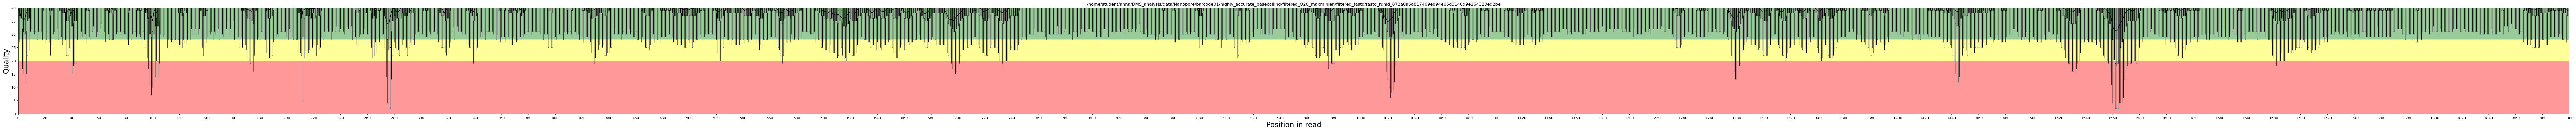

In [9]:
### the code was taken and adapted from https://dmnfarrell.github.io/python/fastq-quality-python ####
from Bio import SeqIO
from matplotlib import patches
import gzip 
bc = "barcode01"
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
filename = f"/home/student/anna/DMS_analysis/data/Nanopore/{bc}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/filtered_fastq/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.fastq.gz"

fastq_parser = SeqIO.parse(gzip.open(filename,"rt"), "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
############ correct for coverage
df = df.fillna(0)
###### 


l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,1900))
ax.set_ylim((0,40))
ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/read_quality_per_pos.pdf", bbox_inches='tight')
plt.show()


In [ ]:
plot_df = araclov2_enr.copy()

fig, axes = plt.subplots(figsize = (40,4))
sns.heatmap(plot_df, xticklabels=annots_R5, yticklabels=plot_df.index, ax = axes, cmap = "viridis")
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 10, rotation = 0)
plt.title(f"{barcode} with Q={quality} filter")

#plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/enrichment_heatmap_combined.pdf", bbox_inches = "tight")
plt.show()

In [502]:
all_counts = {}
data_type = "AA"
quality = 15

for bc_nr in range(1,10): 
    barcode = f"barcode0{bc_nr}"
    counts = pd.read_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
    all_counts[barcode] = counts


In [ ]:
for counts in all_counts.values():
    coverage_plot(counts.sum())

In [19]:
enrichments = {}
data_type = "AA"
quality = 20
data_folder = "Nanopore"

for bc_nr in list(range(1,10)): 
    barcode = f"barcode0{bc_nr}" if bc_nr < 10 else f"barcode{bc_nr}"
    enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    enrichments[barcode] = enrichment_relative


In [168]:
enrichments = {}
data_type = "AA"
quality = 20
data_folder = "Nanopore_P0115"

for bc_nr in list(range(1,13))+[23]: 
    barcode = f"barcode0{bc_nr}" if bc_nr < 10 else f"barcode{bc_nr}"
    enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    enrichments[barcode] = enrichment_relative


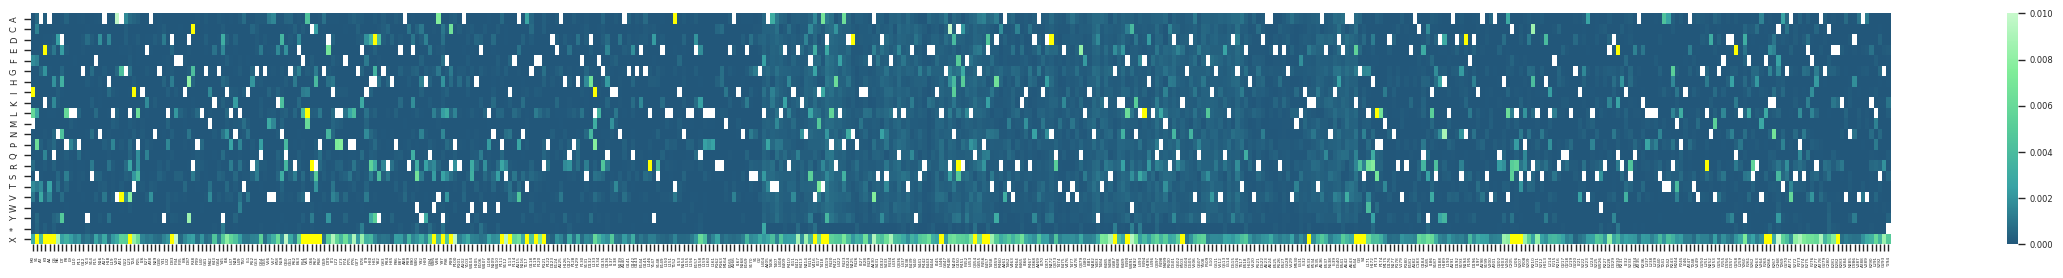

In [57]:
fig, axes = plt.subplots(figsize = (30, 3))
sns.heatmap(enrichments["barcode23"], cmap = my_cmap, xticklabels = annots_R2, yticklabels=True, vmax = 0.01)
axes.set_xticklabels(axes.get_xticklabels(),fontsize = 3)
plt.show()

In [170]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
] , N=256)

In [193]:
barcodes = ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06", "barcode08", "barcode09", "barcode10", "barcode12"]
total_enrichments = pd.DataFrame(index = barcodes, columns = annots)

for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    total_enrichments.loc[barcode] = total_enrichment


vars = total_enrichments.var()
quantile_threshold = np.percentile(vars, 95)
top_indices = [i for i, var in enumerate(vars) if var >= quantile_threshold]
annots_top_var = [annots[i] for i in top_indices]

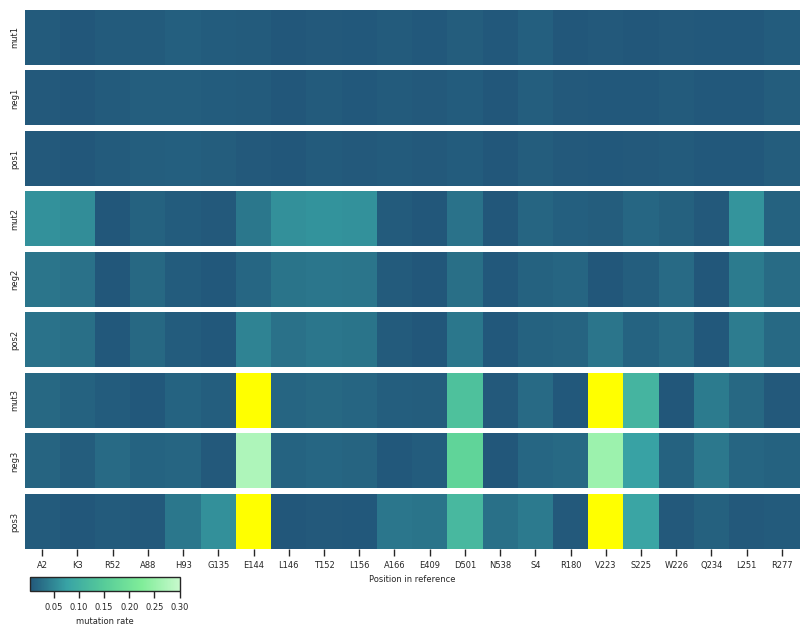

In [241]:
fig, axes = plt.subplots(9, figsize = (10,7))
fig.subplots_adjust(hspace=0.1)

for idx, bc_nr in enumerate([1, 2, 4, 5, 6, 8, 9,10, 12 ]): 
    bc_nr = bc_nr-1
    barcode = f"barcode0{bc_nr+1}" if bc_nr < 9 else f"barcode{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T
    plot_df = plot_df.iloc[:,top_indices]

    my_cmap = cmap#plt.get_cmap('viridis').copy()
    my_cmap.set_over('Yellow')
    annotations = annots_top_var#annots_R2 #if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annots_top_var if bc_nr  == 11 else False, ax = axes[idx], cmap = my_cmap, vmax=0.3, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02}, linewidths = 0)
    axes[idx].set_ylabel(["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"][idx])#("barcode0"+str(bc_nr+1))

    if bc_nr == 11: 
        axes[idx].set_xlabel("Position in reference")
        axes[idx].set_xticklabels(annots_top_var)   

# ## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")
cbar.ax.tick_params()

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/highly_acc_bcall_enrichment_heatmap_all_barcodes_Q{quality}_top_var.pdf", bbox_inches = "tight")
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/highly_acc_bcall_enrichment_heatmap_all_barcodes_Q{quality}_top_var.png", bbox_inches = "tight")

In [ ]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')
    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, vmax=None, cbar = True, yticklabels=False, cbar_kws={"pad" : 0.02} )
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

# ## add at the bottom of the figure horizontally a cbar for the relative counts
# cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
# cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
# cbar.set_label("mutation rate", fontsize = 15)
# cbar.ax.tick_params(labelsize=10)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_bcall_enrichment_heatmap_all_barcodes_Q{quality}_diffCmap.pdf", bbox_inches = "tight")

NameError: name 'cmap' is not defined

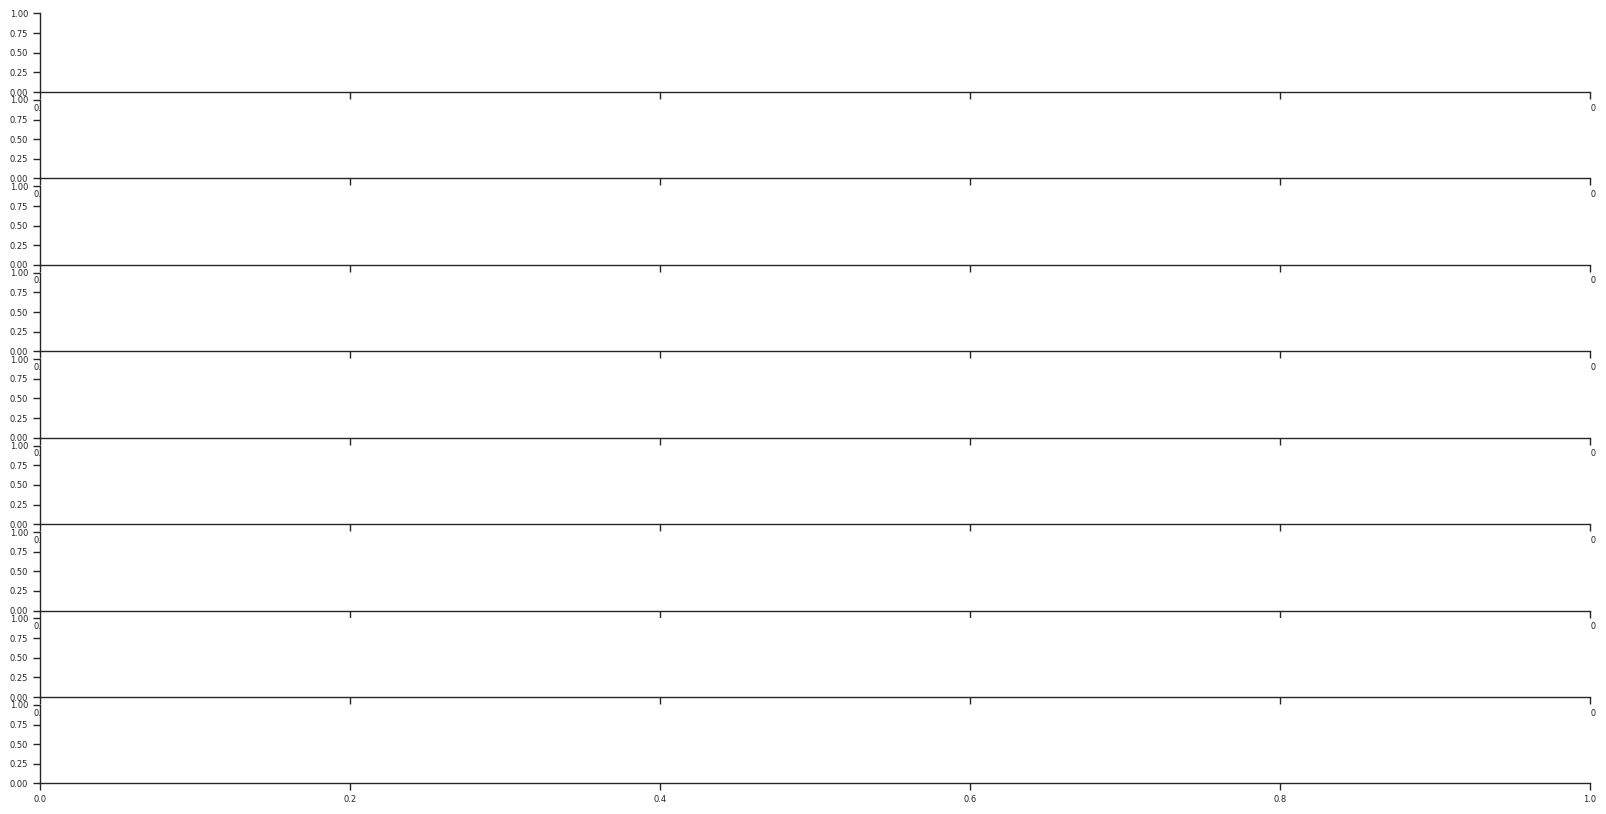

In [169]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    # my_cmap = plt.get_cmap('viridis').copy()
    # my_cmap.set_over('orange')
    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = cmap, vmax=0.3, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02} )
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

# ## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate", fontsize = 15)
cbar.ax.tick_params(labelsize=10)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_bcall_enrichment_heatmap_all_barcodes_Q{quality}_sameCmap.pdf", bbox_inches = "tight")

In [3]:
total_enrichment = pd.DataFrame(columns=annots_R5, index = ["barcode06", "barcode07", "barcode08"]) # ["barcode01", "barcode02", "barcode03", "barcode04"]

threshold = 0.05

for barcode in total_enrichment.index: 

    enr = enrichments[barcode].copy()
    sum_enr = pd.DataFrame(enr.iloc[:-1,:].sum()).T

    total_enrichment.loc[barcode] = sum_enr.values[0]

total_enrichment = total_enrichment.iloc[:,:-1]


In [4]:
## set all values above the threshold to 1
total_enrichment[total_enrichment > threshold] = 1
## set all values below the threshold to 0
total_enrichment[total_enrichment <= threshold] = 0

In [5]:
total_enrichment.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/pymol/total_enrichment_R5_Bcs_Q{quality}_treshold5e-2.csv", header=True, index=False)

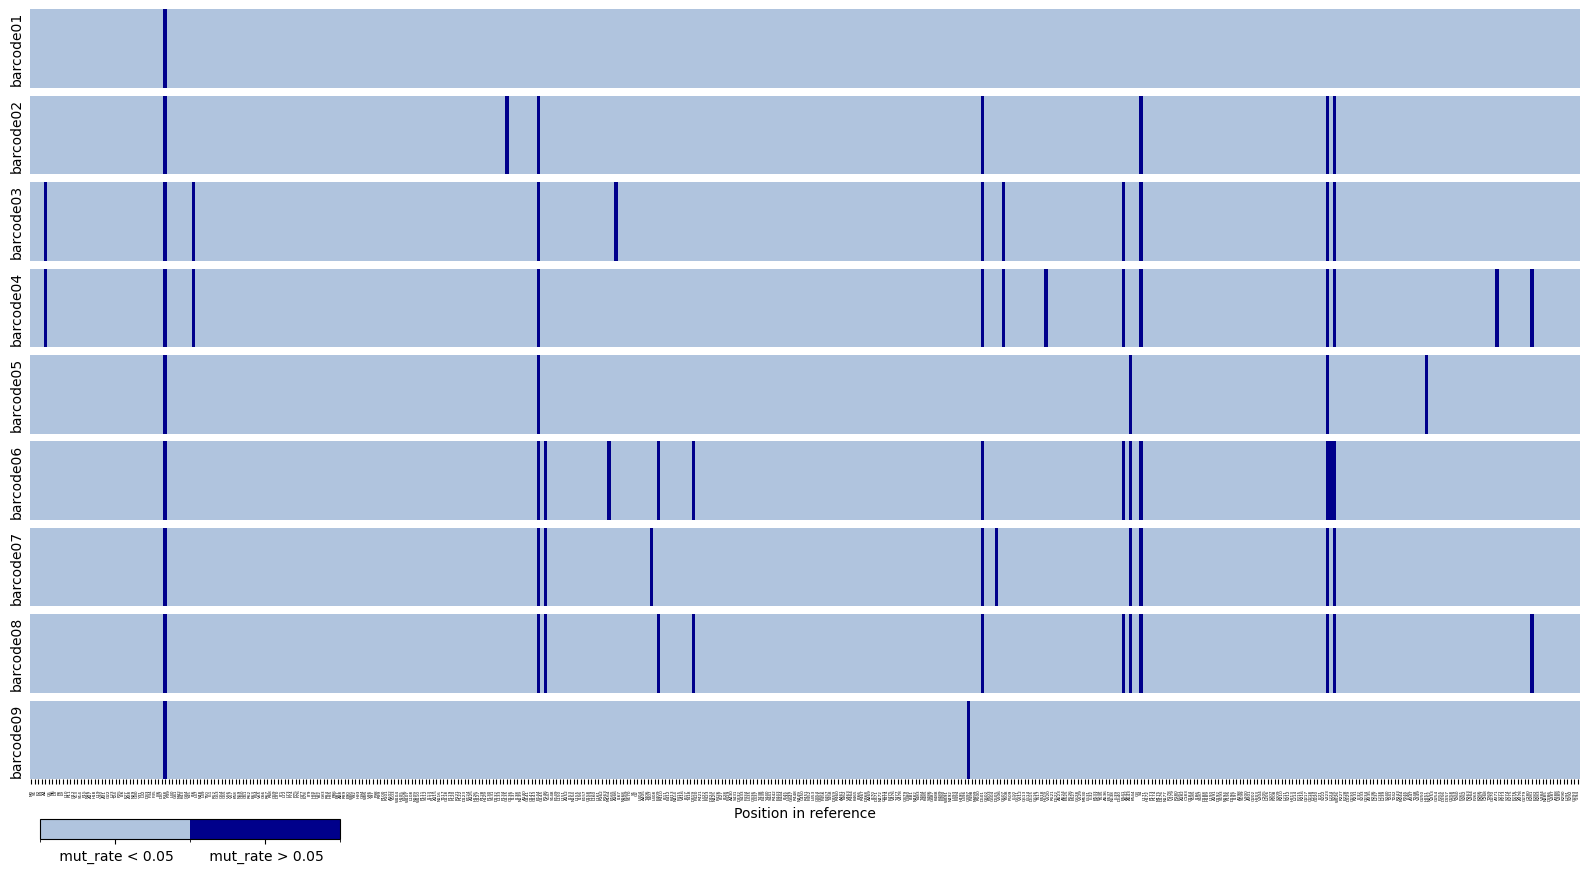

In [8]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)
threshold = 0.05

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')

    colors = ["lightsteelblue", "#00008b"]
    my_cmap = mcolors.ListedColormap(colors)
    # Create a normalization based on threshold
    norm = mcolors.BoundaryNorm([0, threshold, 1], my_cmap.N)

    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, cbar = False, yticklabels=False, norm = norm )
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
# cbar.set_label("mutation rate", fontsize = 15)
# cbar.ax.tick_params(labelsize=10)
## cbar = ax.collections[0].colorbar
cbar.set_ticks([threshold / 2, (threshold + 1) / 2])  # Places ticks at middle of each color range
cbar.set_ticklabels([f" mut_rate < {threshold}", f" mut_rate > {threshold}"])  # Custom labels

plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_basecalling_enrichment_heatmap_all_barcodes_Q{quality}_binary.pdf", bbox_inches = "tight")

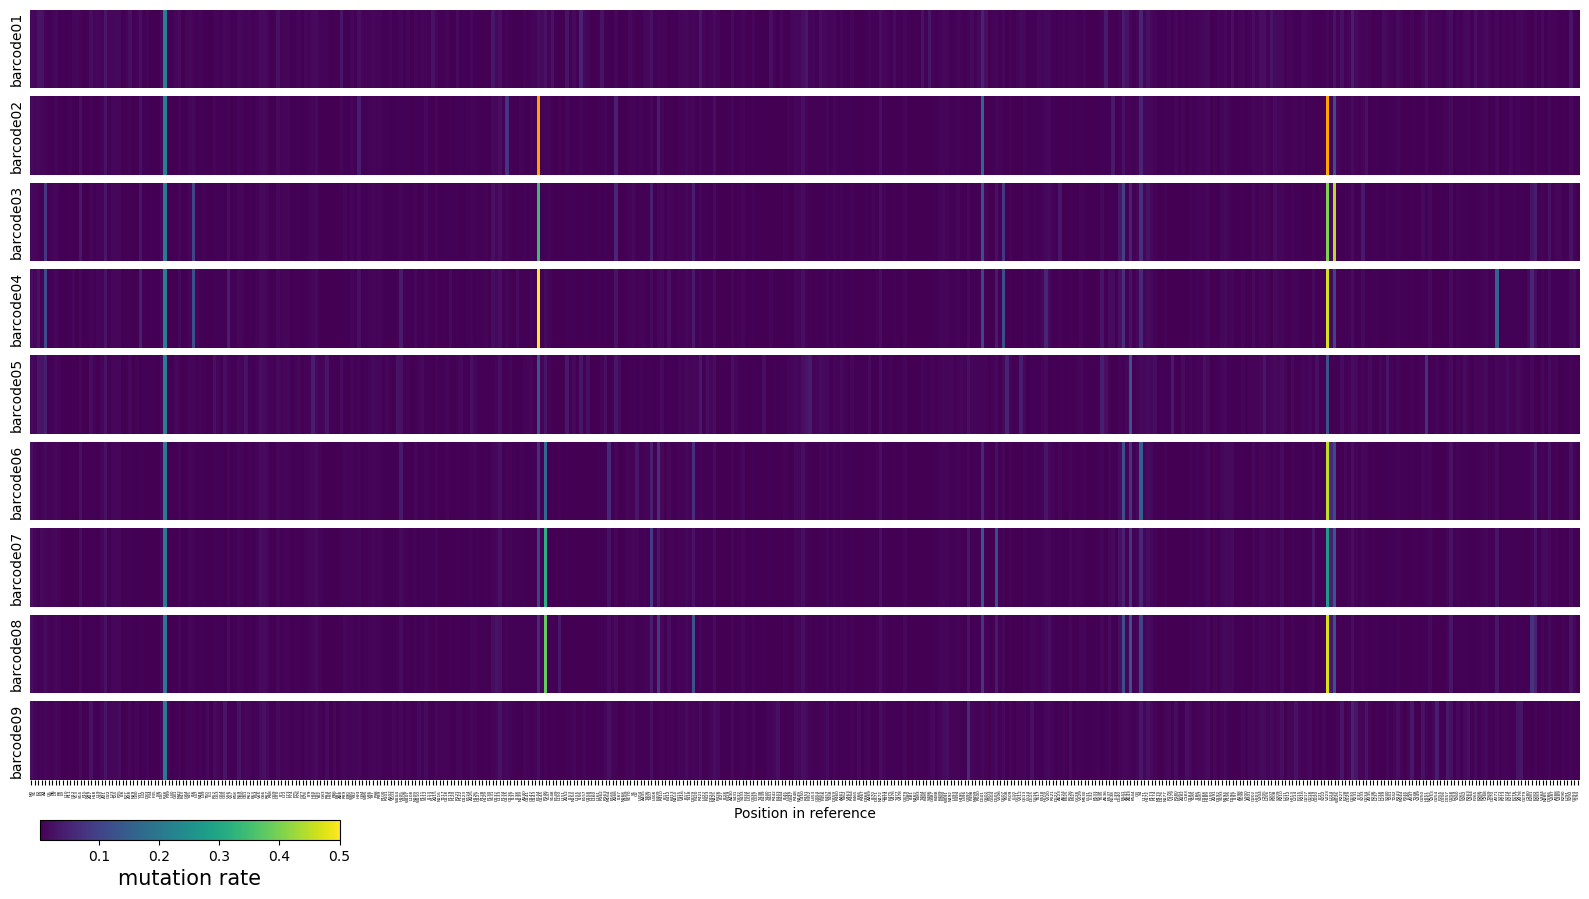

In [91]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')
    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, vmax=0.5, cbar = False, yticklabels=False)
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate", fontsize = 15)
cbar.ax.tick_params(labelsize=10)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_basecallingenrichment_heatmap_all_barcodes_Q{quality}.pdf", bbox_inches = "tight")

In [ ]:
plot_mutation_enrichment(variants_df=enrichment_relative, ref_seq=ref[9:] if data_type != "AA" else translate_dna2aa(ref[9:]), data_type=data_type)

In [48]:
with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads_base_qualitities.csv", "r", newline="") as f:
    reader = csv.reader(f)
    all_quals = [[int(value) if value.isdigit() else np.nan for value in row] for row in reader]

df = pd.DataFrame(all_quals)
df = df.iloc[:,start_arac:end_arac]
df.columns = list(range(len(df.columns)))

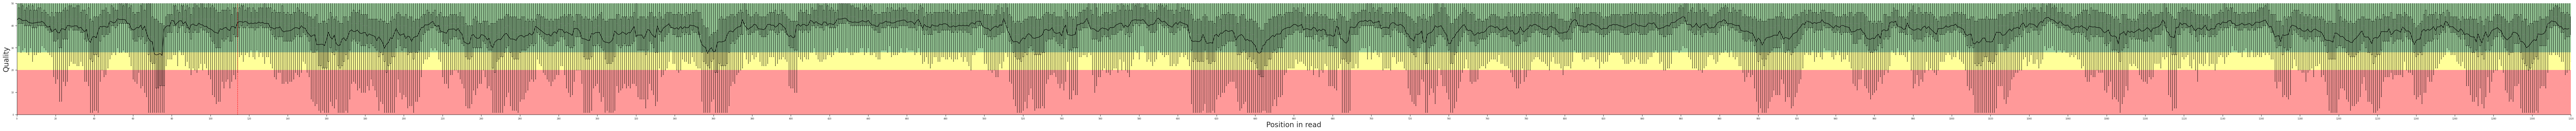

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,30,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,len(df.columns)))
ax.set_ylim((0,50))
#ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
ax.axvline(38*3, color = "red", linestyle = "--", label = "Start of AraC-LOV2", linewidth = 1)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/base_quality_per_pos_AraCLOV2.pdf", bbox_inches='tight')
plt.show()

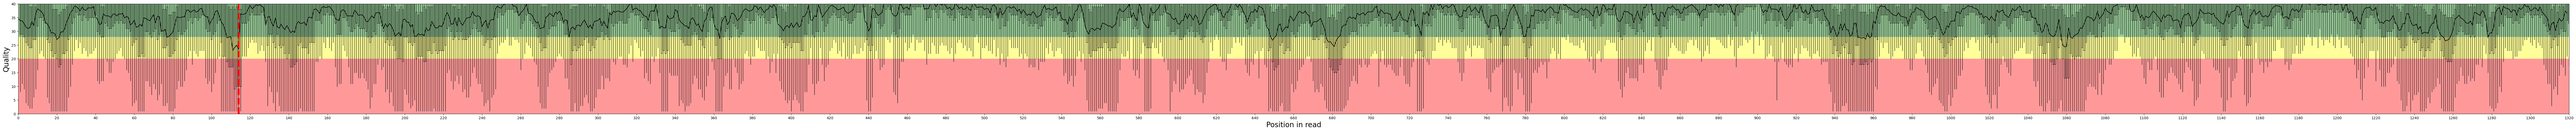

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)

df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,len(df.columns)))
ax.set_ylim((0,40))
#ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
ax.axvline(38*3, color = "red", linestyle = "--", label = "Start of AraC-LOV2", linewidth = 5)
plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/filtered_Q{quality}_maxminlen/base_quality_per_pos_AraCLOV2.pdf", bbox_inches='tight')
plt.show()

## Cooccurrence?

In [25]:

annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294'] #'*294'

annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']#'*294'

annots_WT = ['M0', 'S1', 'A2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'R251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']#'*294'

In [104]:
barcode = "barcode12"
quality = 20
ref = ref_R2# if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else ref_R5 #ref_WT
annots = annots_R2 #if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else annots_R5 # annots_WT 

data_folder = "Nanopore_P0115"
with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
    reader = csv.reader(f)
    all_reads = list(reader)  # Convert the reader object into a list

all_reads = [read[0] for read in all_reads]
# Print the data
print(len(all_reads))

#indels = pd.read_csv(f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0)

AraC_start_R5_seq = "ATGTCCGAGGAAGC"
AraC_WT_start = "atgtccgcgga".upper()
AraC_start_R2_seq = "AtgtccgcgAaag".upper()
AraC_end_seq = "TGAGCGGGTAA"


AraC_start = ref.find(AraC_start_R5_seq)-48 if ref == ref_R5 else ref.find(AraC_start_R2_seq)-48 # 9 nts were cut from the start
AraC_start = ref.find(AraC_WT_start)-48 if ref == ref_WT else AraC_start
AraC_end = ref.find(AraC_end_seq)+ len(AraC_end_seq) -48

reads_roi = [read[AraC_start:AraC_end] for read in all_reads]
ref_roi = ref[AraC_start+48:AraC_end+48]
all_aas = [translate_dna2aa(read) for read in reads_roi]
ref_aa = translate_dna2aa(ref_roi) 


56539


In [105]:
print(ref_aa)
print("\n")

for i in all_aas[:20]: 
    print(i)

MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHDYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDIFGQIINAGQGKGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACRYLSDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISMLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVSLRPRAYWHEWLNWPXXVA

In [19]:
def get_genotype_dict_from_AAseqs(all_Aas, ref_AAseq, ref_aa_annot, not_masked_positions = None, combined = False): 
    """
    Function to get the genotype dictionary from the AA sequences of the reads
    all_Aas: list of AA sequences of the reads
    ref_AAseq: reference AA sequence
    ref_aa_annot: list of the reference AA annotations
    not_masked_positions: list of positions that should be considered

    returns: 
    genotypes: dictionary with the genotypes and their counts
    """
    genotypes = {}

    for read in all_Aas:
        variant = []
        for idx, Aa in enumerate(read): 
            if not_masked_positions and idx not in not_masked_positions: ## if the position is masked, skip
                continue
            else:
                if Aa != "X" and Aa != ref_AAseq[idx]: 
                    observed_mut = f"{ref_aa_annot[idx]}{Aa}" if combined else ref_aa_annot[idx]
                    variant.append(observed_mut)
            
        if len(variant) == 0: 
            variant = "WT"
        else: 
            variant = "_".join(variant)

        genotypes[variant] = genotypes.get(variant, 0) + 1
        
    return genotypes
        

In [138]:
#get idx of these observed anntos in annots
observed_muts_WT_names = ['A2', 'E3', 'R89', 'H93', 'F98', 'S131', 'E144', 'R146', 'L150', 'A152', 'L156', 'M164', 'A166', 'T407', 'E409', 'D419', 'R421', 'S441', 'Q497', 'D501', 'D505', 'H519', 'A523', 'T535', 'N537', 'D540', 'E541', 'A543', 'S4', 'D196', 'V223', 'S225', 'R251', 'R263', 'A278', 'E281', 'S292'] ## E537 statt N537??

observed_muts_R2_names = ['A2', 'K3', 'R89', 'H93', 'F98', 'S131', 'E144', 'L146', 'L150', 'T152', 'L156', 'M164', 'A166', 'T407', 'E409', 'D419', 'R421', 'S441', 'Q497', 'D501', 'D505', 'H519', 'A523', 'T535', 'E537', 'D540', 'E541', 'A543', 'S4', 'D196', 'V223', 'S225', 'L251', 'R263', 'A278', 'E281', 'S292']

observed_muts_R5_names = ['E2', 'E3', 'R89', 'H93', 'F98', 'S131', 'E144', 'R146', 'L150', 'A152', 'I156', 'M164', 'A166', 'T407', 'E409', 'D419', 'R421', 'S441', 'Q497', 'D501', 'D505', 'H519', 'A523', 'T535', 'E537', 'D540', 'E541', 'A543', 'S4', 'D196', 'V223', 'S225', 'H251', 'R263', 'A278', 'E281', 'S292']

muts_prior = ["E3", "R146", "A152", "R251"]

observed_muts_idx = [annots.index(i) for i in muts_prior]#[annots.index(i) for i in observed_muts_R2_names]

ValueError: 'R251' is not in list

In [107]:
araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
total_enrichment = araclov2_enr.iloc[:-1,:].sum()

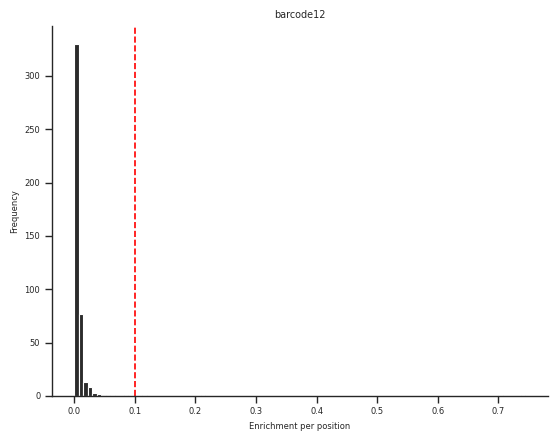

In [108]:
plt.hist(total_enrichment, bins = 100)
#plt.xlim(0, 0.1)
plt.axvline(0.1, color = "red", linestyle = "--")

plt.xlabel("Enrichment per position")
plt.ylabel("Frequency")
plt.title(barcode)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/total_enrichment_hist.pdf", bbox_inches = "tight")
plt.show()

In [116]:
#pos = set([idx for idx, mut_rate in enumerate(total_enrichment) if mut_rate > 0.1] + observed_muts_idx)
pos =[idx for idx, mut_rate in enumerate(total_enrichment)if mut_rate > 0.1] #+ observed_muts_idx
pos=[pos for pos in pos if pos !=38]
pos = list(sorted(set(pos)))
print(len(pos), "positions are included in variant calling")
genotypes = get_genotype_dict_from_AAseqs(all_aas, ref_aa, annots, combined=False, not_masked_positions=pos)


## sort genotypes after size 
genotypes_sorted = dict(sorted(genotypes.items(), key=lambda item: item[1], reverse=True))
sum_genotypes = sum(genotypes_sorted.values())
genotypes_sorted = {k: v/sum_genotypes*100 for k, v in genotypes_sorted.items()}
print("before filtering for percentage",  len(genotypes_sorted), "variants")
## filter for variants with >0.5 percent 
genotypes_sorted = {k: v for k, v in genotypes_sorted.items() if v > 0.5}
print("after filtering for percentage",len( genotypes_sorted), "variants")
print(sum(genotypes_sorted.values()), "percent of all reads can be explained by the filtered genotypes")

3 positions are included in variant calling
before filtering for percentage 8 variants
after filtering for percentage 8 variants
99.99999999999999 percent of all reads can be explained by the filtered genotypes


In [110]:
genotypes

{'E144_V223': 33019,
 'E144': 4915,
 'WT': 6425,
 'D501_V223': 2382,
 'D501': 2358,
 'E144_D501': 767,
 'E144_D501_V223': 1155,
 'V223': 5518}

In [117]:
genotypes_table = pd.DataFrame(columns = ["count"] + annots, index = list(genotypes_sorted.keys()), data = 0, dtype = "float")

for variant, count in genotypes_sorted.items(): 
    genotypes_table.loc[variant, "count"] =count
    if variant != "WT":  
        for mut in variant.split("_"): 
            genotypes_table.loc[variant, mut] = 1.0 #[:-1]

In [118]:
genotypes_table.to_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_table.csv")

In [119]:
annots_R2.index("D501")

270

In [120]:
## filter genotypes_table for columns in pos 
genotypes_table_filt = genotypes_table.iloc[:, 1:]
genotypes_table_filt = genotypes_table_filt.iloc[:, pos]
genotypes_table_filt= pd.concat(( genotypes_table["count"], genotypes_table_filt), axis = 1)


FileNotFoundError: [Errno 2] No such file or directory: '/home/student/anna/DMS_analysis/output/Nanopore/barcode12/highly_accurate_basecalling/filtered_Q20_maxminlen/genotypes_combined_heatmap_pos1perc_filt0_5perc_filt_WT.pdf'

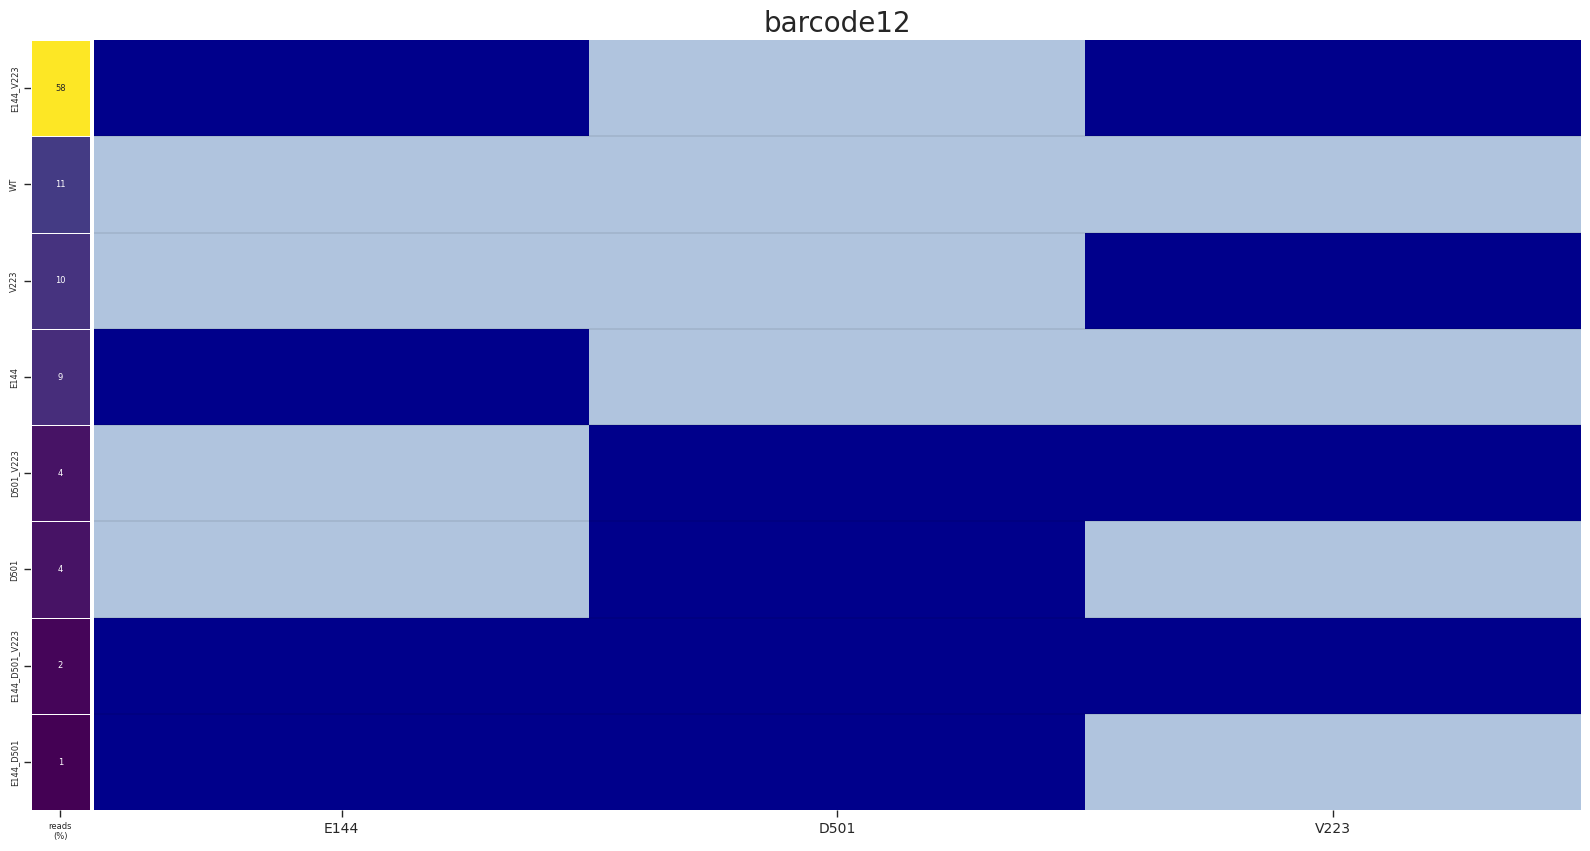

In [121]:
fig, ax = plt.subplots(1,2, figsize=(20, 10), gridspec_kw={"width_ratios": [0.2, 5]})
fig.subplots_adjust(wspace=0.005)
## choose binary colormap

sns.heatmap(genotypes_table_filt.iloc[:, :1], ax=ax[0], cmap="viridis", cbar=False, annot=True, fmt=".0f",
            linewidths=0.5, linecolor="white", cbar_kws={"label": "Occurrences"}, yticklabels=True, xticklabels=["reads\n(%)"])


ax[1] = sns.heatmap(genotypes_table_filt.iloc[:,1:], cbar_kws={"label": "mutation rate"}, cmap = binary_cmap, xticklabels=True, cbar = False, yticklabels=False )
plt.xticks(fontsize = 10)
for y in range(1, genotypes_table_filt.shape[0]):  # Iterate over columns
    ax[1].axhline(y, color="black", lw=0.1)  # Add vertical lines

plt.title(f"{barcode}", fontsize = 20)

plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_combined_heatmap_pos1perc_filt0_5perc_filt_WT.pdf", bbox_inches = "tight")
plt.show()

In [165]:
barcodes = ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05", "barcode06", "barcode07","barcode08", "barcode09", "barcode10", "barcode11", "barcode12"]
total_enrichments = pd.DataFrame(index = barcodes, columns = annots)

for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    total_enrichments.loc[barcode] = total_enrichment


vars = total_enrichments.var()
quantile_threshold = np.percentile(vars, 95)
top_indices = [i for i, var in enumerate(vars) if var >= quantile_threshold]
annots_top_var = [annots[i] for i in top_indices]

In [225]:
all_positions = []
all_aas_all_barcodes = {}

for barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05", "barcode06", "barcode07","barcode08", "barcode09", "barcode10", "barcode11", "barcode12"]:
    quality = 20
    data_type = "AA"
    ref = ref_R2 #if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else ref_R5 #ref_WT
    annots = annots_R2 #if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else annots_R5 # annots_WT 
    mask_pos_with_total_mut_rate_less_than = 0.03

    data_folder = "Nanopore_P0115"
    with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
        reader = csv.reader(f)
        all_reads = list(reader)  # Convert the reader object into a list

    output_dir = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/gentypes/mask_below_{mask_pos_with_total_mut_rate_less_than}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_reads = [read[0] for read in all_reads]
    # Print the data
    print(len(all_reads))

    #indels = pd.read_csv(f"/home/student/anna/DMS_analysis/data/Nanopore/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0)
    indels = None
    AraC_start_R5_seq = "ATGTCCGAGGAAGC"
    AraC_WT_start = "atgtccgcgga".upper()
    AraC_start_R2_seq = "AtgtccgcgAaag".upper()
    AraC_end_seq = "TGAGCGGGTAA"


    AraC_start = ref.find(AraC_start_R5_seq)-48 if ref == ref_R5 else ref.find(AraC_start_R2_seq)-48 # 9 nts were cut from the start
    AraC_start = ref.find(AraC_WT_start)-48 if ref == ref_WT else AraC_start
    AraC_end = ref.find(AraC_end_seq)+ len(AraC_end_seq) -48

    reads_roi = [read[AraC_start:AraC_end] for read in all_reads]
    ref_roi = ref[AraC_start+48:AraC_end+48]
    all_aas = [translate_dna2aa(read) for read in reads_roi]
    ref_aa = translate_dna2aa(ref_roi) 

    print(ref_aa)
    print("\n")

    for i in all_aas[:20]: 
        print(i)

    # araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    # total_enrichment = araclov2_enr.iloc[:-1,:].sum()

    # plt.hist(total_enrichment, bins = 100)
    # #plt.xlim(0, 0.1)
    # plt.axvline(mask_pos_with_total_mut_rate_less_than, color = "red", linestyle = "--")

    # plt.xlabel("Enrichment per position")
    # plt.ylabel("Frequency")
    # plt.title(barcode)
    # plt.savefig(f"{output_dir}/total_enrichment_hist.pdf", bbox_inches = "tight")
    # plt.show()

    # #pos = set([idx for idx, mut_rate in enumerate(total_enrichment) if mut_rate > 0.1] + observed_muts_idx)
    # pos =[idx for idx, mut_rate in enumerate(total_enrichment)if mut_rate > 0.03] #+ observed_muts_idx
    # pos=[pos for pos in pos if pos !=38]
    # pos = list(sorted(set(pos)))
    # all_positions.append(pos)
    all_aas_all_barcodes[barcode] = all_aas

#all_positions = list(set([pos for sublist in all_positions for pos in sublist]))
all_positions = top_indices
for barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05", "barcode06", "barcode07","barcode08", "barcode09", "barcode10", "barcode11", "barcode12"]:
    output_dir = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/gentypes/mask_below_{mask_pos_with_total_mut_rate_less_than}"

    print(len(all_positions), "positions are included in variant calling")
    all_aas = all_aas_all_barcodes[barcode]

    genotypes = get_genotype_dict_from_AAseqs(all_aas, ref_aa, annots, combined=False, not_masked_positions=all_positions)


    ## sort genotypes after size 
    genotypes_sorted = dict(sorted(genotypes.items(), key=lambda item: item[1], reverse=True))
    print(genotypes_sorted)

    sum_genotypes = sum(genotypes_sorted.values())
    genotypes_sorted = {k: v/sum_genotypes*100 for k, v in genotypes_sorted.items()}
    print("before filtering for percentage",  len(genotypes_sorted), "variants")
    ## filter for variants with >0.5 percent 
    #genotypes_sorted = {k: v for k, v in genotypes_sorted.items() if v > 0.1}
    print("after filtering for percentage",len( genotypes_sorted), "variants")
    print(sum(genotypes_sorted.values()), "percent of all reads can be explained by the filtered genotypes")

    genotypes_table = pd.DataFrame(columns = ["count"] + annots, index = list(genotypes_sorted.keys()), data = 0, dtype = "float")

    for variant, count in genotypes_sorted.items(): 
        genotypes_table.loc[variant, "count"] =count
        if variant != "WT":  
            for mut in variant.split("_"): 
                genotypes_table.loc[variant, mut] = 1.0 #[:-1]


    genotypes_table.to_csv(f"{output_dir}/genotypes_table.csv")

    fig, ax = plt.subplots(1,2, figsize=(50, 10), gridspec_kw={"width_ratios": [0.1, 5]})
    fig.subplots_adjust(wspace=0.005)

    ## choose binary colormap
    # binary_cmap = LinearSegmentedColormap.from_list("binary_blue", ["lightsteelblue", "#00008b"])

    # sns.heatmap(genotypes_table.iloc[:, :1], ax=ax[0], cmap="viridis", cbar=False, annot=True, fmt=".0f",
    #             linewidths=0.5, linecolor="white", cbar_kws={"label": "Occurrences"}, yticklabels=True, xticklabels=["reads\n(%)"])


    # ax[1] = sns.heatmap(genotypes_table.iloc[:,1:], cbar_kws={"label": "mutation rate"}, cmap = binary_cmap, xticklabels=True, cbar = False, yticklabels=False )
    # plt.xticks(fontsize = 5)
    # for y in range(1, genotypes_table.shape[0]):  # Iterate over columns
    #     ax[1].axhline(y, color="black", lw=0.1)  # Add vertical lines

    # ### show all annots not included in observed_muts in grey in the xticks
    # for i, annot in enumerate(annots): 
    #     if i not in pos: 
    #         ax[1].get_xticklabels()[i].set_color("grey")

    # plt.title(f"{barcode}", fontsize = 20)
    # #plt.savefig(f"{output_dir}/genotypes_combined_heatmap_filto1perc.pdf", bbox_inches = "tight")
    # plt.show()

    plt.close()
    ## filter genotypes_table for columns in pos 
    genotypes_table_filt = genotypes_table.iloc[:, 1:]
    genotypes_table_filt = genotypes_table_filt.iloc[:, pos]
    genotypes_table_filt= pd.concat(( genotypes_table["count"], genotypes_table_filt), axis = 1)


79412
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYRXWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDIFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDEXXFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSAKAQDDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLN

In [227]:
len(all_positions)

22

In [236]:
all_variants = pd.DataFrame(dtype = float)

#[13, 16, 17,19, 21]
for barcode in ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06", "barcode08","barcode09", "barcode10", "barcode12"]: 
    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/{barcode}/highly_accurate_basecalling/filtered_Q20_maxminlen/gentypes/mask_below_0.03/"
    genotypes = pd.DataFrame(pd.read_csv(f"{FigFolder}/genotypes_table.csv", index_col = 0).T.iloc[0,:]).T
    genotypes.index = [barcode]    
    all_variants = pd.concat([all_variants, genotypes], axis = 0)


# all_right_linkers.fillna(0, inplace = True)
all_variants.fillna(0, inplace = True)

In [229]:
all_variants

,WT,H93,S4,D501,G135,R277,R52,A166,A88,A2,...,R52_G135_E409_D501,E144_T152_A166_D501_V223,A2_E144_A166_N538,A2_K3_R52_T152_L156,A2_S4_V223_S225,A166_E409_N538_V223,H93_E144_A166_V223_R277,A2_K3_G135_D501_S225,A88_H93_E144_S4_V223,R52_G135_D501_N538_V223
barcode01,89.805067,0.946960,0.914220,0.701405,0.643480,0.624591,0.491110,0.489850,0.450813,0.445776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode02,88.670389,0.888300,0.869373,0.640358,0.668749,0.760228,0.555818,0.512287,0.799344,0.434687,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode04,88.553429,0.937771,0.779071,0.590555,0.695393,0.796384,0.528999,0.510724,0.802154,0.444359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode05,67.349056,0.777952,1.454339,2.209240,0.543846,1.236080,0.432916,0.660539,1.223834,0.432196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode06,71.594888,0.839182,1.289798,2.075054,0.597621,2.112728,0.511930,0.712122,1.758144,0.380439,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode08,67.306961,0.716806,1.175876,2.499311,0.542359,1.861203,0.516126,0.716150,1.663803,0.334466,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode09,10.278389,0.271892,0.295369,4.644548,0.120113,0.320483,0.505020,0.212927,0.328127,0.082987,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode10,27.769365,0.832904,0.589638,8.791404,0.285153,1.277549,1.841410,0.304485,1.380655,0.162714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode12,4.046764,0.134420,0.067210,1.876581,0.182175,0.159182,0.201631,0.205168,0.205168,0.021224,...,0.001769,0.001769,0.001769,0.001769,0.001769,0.001769,0.001769,0.001769,0.001769,0.001769


In [237]:
## filter df for linkers that have a overall occurrence of higher than 1 % 
all_variants = all_variants.loc[:, all_variants.max() > 1]
all_variants


,WT,S4,D501,R277,R52,A88,E144,W226,L251,V223,...,A2_K3,H93_E409_N538,E144_D501,D501_Q234,E144_S225,A2_K3_L146_T152_L156_L251,E144_D501_V223,G135_D501_V223,L146_T152_L156,A166_S4_S225
barcode01,89.805067,0.914220,0.701405,0.624591,0.491110,0.450813,0.441999,0.366443,0.334962,0.317332,...,0.007556,0.001259,0.001259,0.001259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode02,88.670389,0.869373,0.640358,0.760228,0.555818,0.799344,0.456137,0.471909,0.346361,0.354563,...,0.011356,0.000000,0.003785,0.001893,0.003785,0.000631,0.000631,0.000631,0.000000,0.000000
barcode04,88.553429,0.779071,0.590555,0.796384,0.528999,0.802154,0.446283,0.551121,0.329903,0.356834,...,0.019236,0.000000,0.003847,0.005771,0.000962,0.000962,0.000962,0.000962,0.000962,0.000000
barcode05,67.349056,1.454339,2.209240,1.236080,0.432916,1.223834,2.645758,1.148920,2.730756,0.684310,...,1.596243,0.001441,0.054745,0.319825,0.038898,1.959287,0.002881,0.000000,1.246164,0.000000
barcode06,71.594888,1.289798,2.075054,2.112728,0.511930,1.758144,1.603753,1.962769,1.986408,0.441014,...,0.814804,0.000000,0.039152,0.186895,0.019207,1.040851,0.001477,0.000739,0.511192,0.001477
barcode08,67.306961,1.175876,2.499311,1.861203,0.516126,1.663803,2.169436,2.080246,2.151074,1.153579,...,0.839443,0.013772,0.090502,0.285935,0.104275,0.897811,0.032135,0.009837,0.680736,0.014428
barcode09,10.278389,0.295369,4.644548,0.320483,0.505020,0.328127,6.917957,0.326489,0.408384,8.561866,...,0.067154,0.304650,1.266099,2.112349,2.378236,0.579272,0.799843,0.278444,0.120659,0.341776
barcode10,27.769365,0.589638,8.791404,1.277549,1.841410,1.380655,5.437234,1.324269,0.528419,4.718714,...,0.114383,0.444645,0.782962,2.426215,0.797461,0.773296,0.185269,0.425313,0.107939,0.367315
barcode12,4.046764,0.067210,1.876581,0.159182,0.201631,0.205168,3.668264,0.183944,0.061904,5.704027,...,0.008843,1.054140,0.718088,0.514689,2.263924,0.088435,1.722705,2.757389,0.015918,1.158492


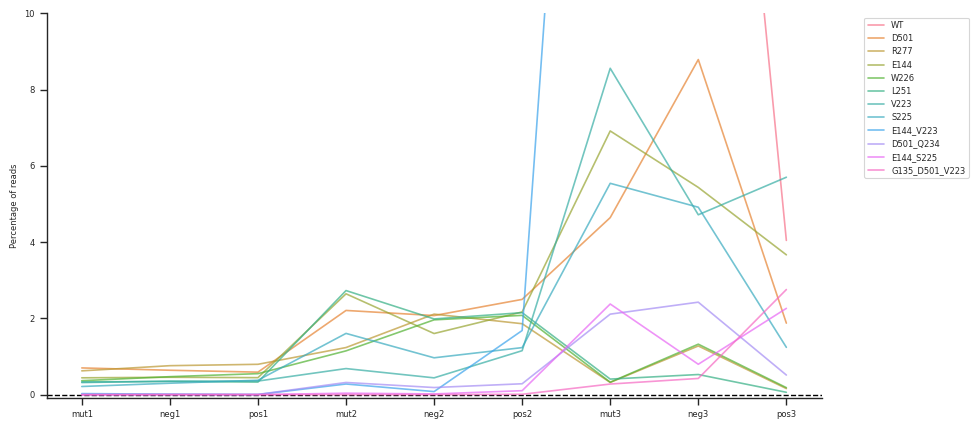

In [231]:

# Number of distinct colors
colors = sns.color_palette("husl", all_variants.shape[1]) 


fig, axis = plt.subplots(1,1, figsize=(10, 5))
plt.axhline(0, color = "black", linestyle = "--", linewidth= 1)
for i in all_variants.columns:
    plt.plot(all_variants[i], label = i, color = colors[all_variants.columns.get_loc(i)], alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-0.1,10)#
plt.xticks(range(len(["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])), ["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])
plt.ylabel("Percentage of reads")
plt.show()

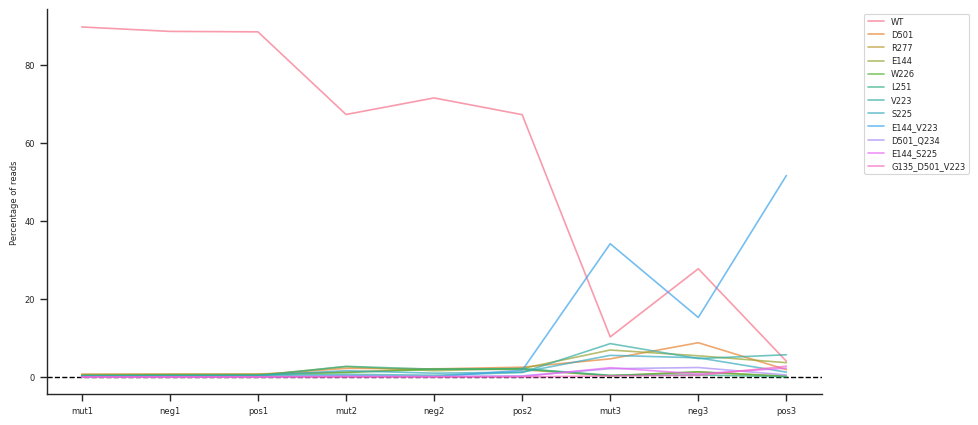

In [213]:

  # Number of distinct colors
colors = sns.color_palette("husl", all_variants.shape[1]) 


fig, axis = plt.subplots(1,1, figsize=(10, 5))
plt.axhline(0, color = "black", linestyle = "--", linewidth= 1)
for i in all_variants.columns:
    plt.plot(all_variants[i], label = i, color = colors[all_variants.columns.get_loc(i)], alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])), ["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])
plt.ylabel("Percentage of reads")
plt.show()


## Pymol

In [180]:
from Bio import PDB
import numpy as np
import io
import pandas as pd

In [212]:
def overwrite_b_factors(pdb_str: str, bfactors: np.ndarray) -> str:
    """From the original AF2 github: Overwrites the B-factors in pdb_str with contents of bfactors array."""

    parser = PDB.MMCIFParser(QUIET=True)
    handle = io.StringIO(pdb_str)
    structure = parser.get_structure('', handle)

    curr_resid = ('', '', '')
    idx = -1

    for atom in structure.get_atoms():
        atom_resid = atom.parent.get_id()
        if atom_resid != curr_resid:
            idx += 1
            if idx >= bfactors.shape[0]:
                raise ValueError('Index into bfactors exceeds number of residues. '
                                 'B-factors shape: {shape}, idx: {idx}.')
        curr_resid = atom_resid
        atom.bfactor = bfactors[idx]

    new_pdb = io.StringIO()
    pdb_io = PDB.PDBIO()
    pdb_io.set_structure(structure)
    pdb_io.save(new_pdb)
    return new_pdb.getvalue()

In [235]:
color_pos = ["E144", "A271"]
init_muts = ["E3", "R146", "A152", "R251"]
color_pos_idx = [annots_WT.index(i) for i in color_pos]
init_muts_idx = [annots_WT.index(i) for i in init_muts]

array = np.zeros(len(annots_WT)-1)
array[color_pos_idx] = 1
array[init_muts_idx] = 2

path = "/home/student/anna/DMS_analysis/data/pymol/alphafold_arac_s170_lov2_wt/fold_arac_s170_lov2_wt_model_0.cif"#'/Users/annavonbachmann/Downloads/fold_2025_02_05_13_34_my_first_job/fold_2025_02_05_13_34_my_first_job_model_0.cif'
with open(path,'r') as f:
    pdb_str = f.read()
    

new_pdb_str = overwrite_b_factors(pdb_str,array)

with open(f"/home/student/anna/DMS_analysis/data/pymol/alphafold_arac_s170_lov2_wt/colored_after_Nanopore/cooccurrence/fold_arac_s170_lov2_wt_dimer_model_0_colored_after_pos{color_pos[0]}_{color_pos[1]}.pdb", 'w') as f:
    f.write(new_pdb_str) #'/Users/annavonbachmann/Downloads/fold_2025_02_05_13_34_my_first_job/fold_2025_02_05_13_34_my_first_job_model_0_Mut1_coverage.pdb'

### set right color sceme in pymol:

set_color grey_custom, [0.5, 0.5, 0.5]
set_color orange_custom, [1.0, 0.5, 0.0]
set_color blue_custom, [0.0, 0.0, 1.0]

color grey_custom, (b < 0.5)  
color blue_custom, (b > 0.5 and b < 1.5) 
color orange_custom, (b > 1.5) 

rebuild

<Axes: >

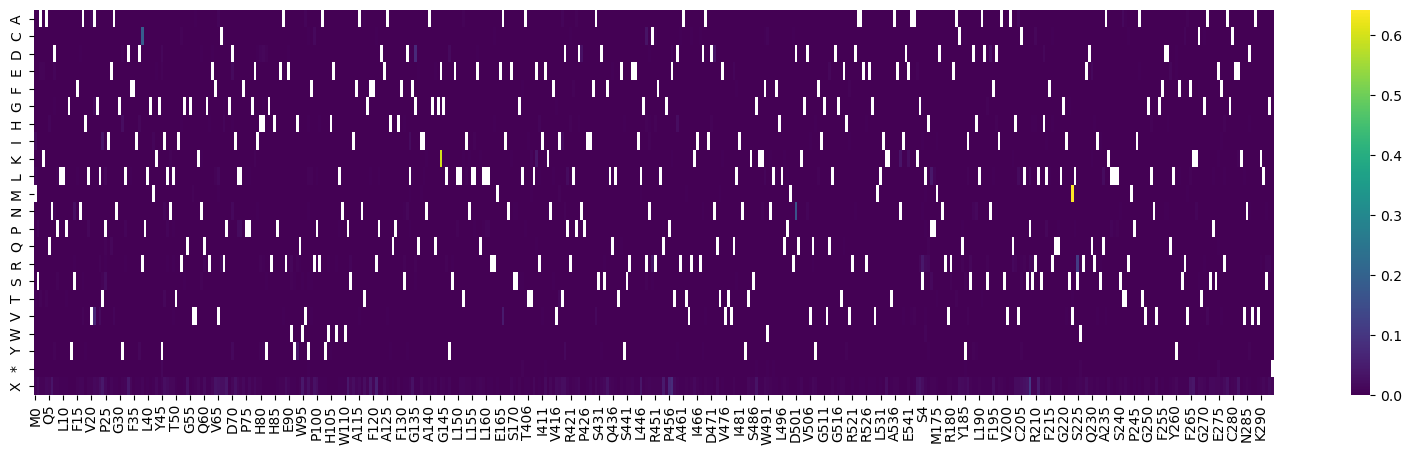

In [493]:
plt.figure(figsize=(20, 5))
sns.heatmap(araclov2_enr, cmap = "viridis")

In [428]:
idxs_38 = [idx for idx, aa in enumerate(all_aas) if aa[38] != "R" and aa[38] != "X"]

In [456]:
C38mut = [read for idx, read in enumerate(all_reads) if idx in idxs_38]


In [462]:
variants38 = {}
for x in C38mut: 
    variants38[x[AraC_start+38*3:AraC_start+38*3+3]] = variants38.get(x[AraC_start+38*3:AraC_start+38*3+3], 0) + 1


In [463]:
variants38

{'GGC': 453,
 'AGC': 369,
 'CAC': 417,
 'TGC': 40154,
 'AAG': 25,
 'GAC': 22,
 'TTC': 15,
 'CTC': 18,
 'CCC': 42,
 'TAA': 4,
 'CTG': 11,
 'TAG': 11,
 'CCT': 14,
 'AAC': 17,
 'GTG': 1,
 'GGG': 2,
 'TGG': 7,
 'CCA': 8,
 'TCC': 2,
 'TAC': 6,
 'AGT': 7,
 'TGT': 21,
 'CCG': 6,
 'CAG': 9,
 'TTG': 5,
 'TGA': 11,
 'CTT': 6,
 'ACC': 1,
 'CAT': 2,
 'TCA': 2,
 'CTA': 5,
 'GAA': 1,
 'AAA': 1,
 'GCC': 2,
 'GGT': 2,
 'ACA': 1,
 'GAG': 1}

In [410]:
print(all_reads[idxs_38[0]])

CTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGA-CC---TTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATAG-CCGCTGGGTATGAAAGGCTAT-CTCTGAACCTAA--TTTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAACTGCTGTGCCGCCAGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCAC-GACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCG